# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Callable
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
torch.manual_seed(42)

idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [10]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [12]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [13]:
acc_type

{'max': [0.24699999392032623,
  0.8754000067710876,
  0.8889999985694885,
  0.8709999918937683,
  0.8867999911308289,
  0.8989999890327454,
  0.897599995136261,
  0.9005999565124512,
  0.899399995803833,
  0.9075999855995178],
 'mean': [0.2655999958515167,
  0.871399998664856,
  0.8889999985694885,
  0.8949999809265137,
  0.8894000053405762,
  0.9027999639511108,
  0.9025999903678894,
  0.9034000039100647,
  0.8989999890327454,
  0.9039999842643738]}

Baseline best cases:
- max = 0.9076
- mean = 0.904

# Experiments

- GRU/LSTM
- ReLU for linear
- Different optimizer (AdamW)
- Gradient schedular

Для начала создадим функцию train, чтобы каждый раз просто её вызывать, вместо переписывания цикла снова и снова

In [14]:
def train(model: Callable,
          train_loader: DataLoader,
          eval_loader: DataLoader,
          num_epochs: int = 5,
          optimizer: torch.optim.Optimizer = None,
          criterion = None,
          scheduler: Callable = None,
          device: str = 'cpu'):

    eval_steps = len(train_dataloader) // 2

    # в качестве значений по умолчанию используются параметры из самого ноутбука
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

    acc = []
    losses = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_loader))
                model.train()

        # если у нас есть scheduler, то мы его применем
        if not scheduler is None:
            scheduler.step()

    losses.append(sum(epoch_losses) / len(epoch_losses))

    return acc, losses

Прогоним модель ещё раз, чтобы убедиться что:
- Функция правильно написана
- Дальнейшее обучение смысла не имеет

In [15]:
train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.9065999984741211,
  0.9063999652862549,
  0.9063999652862549,
  0.8991999626159668,
  0.9052000045776367,
  0.9007999897003174,
  0.9052000045776367,
  0.9025999903678894,
  0.9017999768257141,
  0.8955999612808228],
 [0.09452632189371313])

## Меньше шаг - 0.9102

Итак, наша модель упёрлась в её потолок немногим больше 0.9. Как мы видели, она достаточно быстро пришла к потолку. Попробуем уменьшить lr, может это поможет модели за счёт меньших шагов лучше попасть в минимум.

*Оптимизатор мы тоже поменяем с Adam на AdamW, но это скорее для дальнейших приготовлений. В данном случае да, мы ещё получаем небольшое изменение в виде weight_decay, так лучше не делать на самом деле

*Также далее мы будем считать только "mean". Одна из причин - его результаты в различных прогонах такие же или лучше, чем у max, а также сокращение проверок с почти 14 минут до 6:40

In [16]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2541999816894531,
  0.8529999852180481,
  0.8743999600410461,
  0.8901999592781067,
  0.8913999795913696,
  0.8905999660491943,
  0.9047999978065491,
  0.8989999890327454,
  0.9101999998092651,
  0.9075999855995178],
 [0.17366659124158323])

## GRU - 0.8998

Итак, сейчас мы попробуем заменить RNN слой на GRU. Так механизм запоминания может помочь нам сохранить и передать какие-то важные параметры дальше. Для этого просто меняем nn.RNN на nn.GRU, параметры можно оставить те же

In [19]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [20]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2295999974012375,
  0.824400007724762,
  0.8631999492645264,
  0.8835999965667725,
  0.8930000066757202,
  0.8837999701499939,
  0.8923999667167664,
  0.8998000025749207,
  0.8995999693870544,
  0.899399995803833],
 [0.19790371306637922])

## GRU-BiDir - 0.9114

Несмотря на то, что GRU не дала нам прироста, мы можем попробовать улучшить модель, "пустив память" в двух направлениях с помощью флага bidirectional в nn.GRU

In [21]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [22]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.26659998297691345,
  0.8761999607086182,
  0.8941999673843384,
  0.8905999660491943,
  0.9085999727249146,
  0.9077999591827393,
  0.9031999707221985,
  0.9081999659538269,
  0.9113999605178833,
  0.9063999652862549],
 [0.06877031735001753])

## GRU-BiDir 2 layers - 0.9114

Отлично, давайте добавим ещё одни GRU слой, чтобы попробовать запомнить и передать какие-нибудь нужные признаки ещё раз, сделав своеобразный "отбор". Для этого поменяем параметр num_layers в GRU, сделав его равным 2.

In [23]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [24]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2619999945163727,
  0.8847999572753906,
  0.8813999891281128,
  0.8939999938011169,
  0.9107999801635742,
  0.9063999652862549,
  0.9103999733924866,
  0.9113999605178833,
  0.9043999910354614,
  0.9031999707221985],
 [0.07007091784734899])

## ReLU - 0.9134

Теперь давайте добавим функцию активации для линейного слоя. Куда его ставить - перед дропаутом линейного слоя

In [25]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.relu(self.linear(self.non_lin(output))))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [26]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.26479998230934143,
  0.8831999897956848,
  0.9031999707221985,
  0.9052000045776367,
  0.9133999943733215,
  0.9139999747276306,
  0.9138000011444092,
  0.9097999930381775,
  0.9099999666213989,
  0.9075999855995178],
 [0.08194532644177477])

## Weight Decay - 0.9084

В прошлом прогоне машина чуть быстрее достигла пика (и достигла нового максимума), однако так и не смогла достичь 0.915. Давайте увеличим weight decay.

Weight Decay представляет собой L2 регуляризацию, встроенную в оптимизатор AdamW. Попробуем немного увеличить значение, чтобы получить лучше результат (может мы слишком подстраиваемся под обучающую выборку, из-за чего не может преодолеть потолок в 0.913)

In [27]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=15e-3)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2595999836921692,
  0.8741999864578247,
  0.8939999938011169,
  0.8991999626159668,
  0.9085999727249146,
  0.9063999652862549,
  0.9061999917030334,
  0.9047999978065491,
  0.9083999991416931,
  0.9073999524116516],
 [0.0864857172915712])

## Plateau Scheduler -  0.911

Раз мы достигаем своеобразного плато, попробуем использовать scheduler. Его идея заключается в том, что мы уменьшим на lr когда достигнем плато. Для этого немного перепишем нашу функцию обучения, заменив часть со scheduler после прогона всех бачей

In [37]:
def train(model: Callable,
          train_loader: DataLoader,
          eval_loader: DataLoader,
          num_epochs: int = 5,
          optimizer: torch.optim.Optimizer = None,
          criterion = None,
          scheduler: Callable = None,
          device: str = 'cpu'):

    eval_steps = len(train_dataloader) // 2

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

    acc = []
    losses = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_loader))
                model.train()
        if not scheduler is None:
            scheduler.step(acc[-1])

    losses.append(sum(epoch_losses) / len(epoch_losses))

    return acc, losses

In [29]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=15e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2549999952316284,
  0.8747999668121338,
  0.8937999606132507,
  0.9021999835968018,
  0.9083999991416931,
  0.9109999537467957,
  0.9107999801635742,
  0.9059999585151672,
  0.9085999727249146,
  0.9089999794960022],
 [0.08116885706155251])

## StepLR Scheduler - 0.8796

Давайте попробуем другой планировщик, который будет каждую эпоху меньшать lr в 0.5 раз. Плюс к этому давайте сделаем lr побольше, так как он будет сильнее уменьшаться

In [30]:
def train(model: Callable,
          train_loader: DataLoader,
          eval_loader: DataLoader,
          num_epochs: int = 5,
          optimizer: torch.optim.Optimizer = None,
          criterion = None,
          scheduler: Callable = None,
          device: str = 'cpu'):

    eval_steps = len(train_dataloader) // 2

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

    acc = []
    losses = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_loader))
                model.train()
        if not scheduler is None:
            scheduler.step()

    losses.append(sum(epoch_losses) / len(epoch_losses))

    return acc, losses

In [31]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=15e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.2393999993801117,
  0.8795999884605408,
  0.8241999745368958,
  0.864799976348877,
  0.8607999682426453,
  0.8628000020980835,
  0.8673999905586243,
  0.8759999871253967,
  0.8723999857902527,
  0.8797999620437622],
 [0.30550281941095986])

## LSTM - 0.9176

Теперь попробуем вместо GRU использовать LSTM (аналогично тому, как мы меняли RNN на GRU)

In [32]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.relu(self.linear(self.non_lin(output))))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [33]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=15e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=5,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.24159999191761017,
  0.9047999978065491,
  0.9109999537467957,
  0.9157999753952026,
  0.915399968624115,
  0.9143999814987183,
  0.920199990272522,
  0.9131999611854553,
  0.9175999760627747,
  0.9109999537467957],
 [0.01655143525659029])

## LSTM + GRU - 0.9158

Ура, мы преодолели барьер в 0.915. Теперь давайте попробуем добавить после LSTM слоя ещё GRU слой (а вернее 2), может так мы сможем лучше отобрать (запомнить) необходимое.

In [38]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.relu(self.linear(self.non_lin(output))))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [35]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=15e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=10,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.25679999589920044,
  0.8959999680519104,
  0.9085999727249146,
  0.9129999876022339,
  0.9157999753952026,
  0.9129999876022339,
  0.9147999882698059,
  0.9129999876022339,
  0.9107999801635742,
  0.9120000004768372],
 [0.01468322737030685])

## Less penalty 0.9178 (лучший результат)

Хм, мы не поставили нового рекорда, но вместе с тем быстро достигли максимума, но также быстро отскачили от него, и не вернулись из-за маленького lr. Что если попробовать начать чуть меньше улучшать шаг, чтобы успеть вернуться к макимуму и уже от него идти маленькими шажками?

In [36]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type = 'mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=15e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

train(model=model,
      train_loader=train_dataloader,
      eval_loader=eval_dataloader,
      num_epochs=10,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      device=device)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

([0.25679999589920044,
  0.8903999924659729,
  0.9113999605178833,
  0.9034000039100647,
  0.9143999814987183,
  0.917199969291687,
  0.9177999496459961,
  0.9107999801635742,
  0.9139999747276306,
  0.9091999530792236],
 [0.11501342168599367])

# Итог

Мы достигли лучшего результата во время нашего последнего прогона (как раз перед отключением от GPU Colab и последующего вайпа нашего окружения:)

По итогу прирост дали техники:
- ReLU для линейного слоя
- Двунаправленные LSTM/GRU, которые могли передавать важный контекст в обе стороны
- Уменьшение lr (сразу или постепенной с помощью планировщика) в некоторых случаях (как видно, StepLR не сразу дал прирост)

Однако стоит понимать, что их необходимо применять не всегда. Нам пришлось подобрать величину уменьшения нашего lr с помощью StepLR, а также использовать как основу LSTM (+ GRU), вместо RNN/GRU. В целом LSTM дал нам наибольший прирост после GRU, что делает его более подходящим для нашей задачи (хоть и его вычисление стоит дороже).

Планировщик Плато хоть и дал нам небольшой прирост, но по итогу никак не помог поставить рекорд.

Weight decay хоть и улудшило результаты, но значительно сгладило наш график одним из первых (в плане среди методов, если идти по порядку)

Давайте разберёмся с графиками. Для наглядности мы не будем вствлять сюда первые значения accuracy у моделей, потому что у всех она примерно одинаково низкая, да и наш график тогда будет больше масштабом, а значит наблюдать различия в районе 0.9 будет не очень удобно.

In [4]:
baseline_max = [0.8754000067710876,
  0.8889999985694885,
  0.8709999918937683,
  0.8867999911308289,
  0.8989999890327454,
  0.897599995136261,
  0.9005999565124512,
  0.899399995803833,
  0.9075999855995178]

baseline_mean = [0.871399998664856,
  0.8889999985694885,
  0.8949999809265137,
  0.8894000053405762,
  0.9027999639511108,
  0.9025999903678894,
  0.9034000039100647,
  0.8989999890327454,
  0.9039999842643738]

lower_lr = [0.8529999852180481,
  0.8743999600410461,
  0.8901999592781067,
  0.8913999795913696,
  0.8905999660491943,
  0.9047999978065491,
  0.8989999890327454,
  0.9101999998092651,
  0.9075999855995178]

gru = [0.824400007724762,
  0.8631999492645264,
  0.8835999965667725,
  0.8930000066757202,
  0.8837999701499939,
  0.8923999667167664,
  0.8998000025749207,
  0.8995999693870544,
  0.899399995803833]

gru_bidir = [0.8761999607086182,
  0.8941999673843384,
  0.8905999660491943,
  0.9085999727249146,
  0.9077999591827393,
  0.9031999707221985,
  0.9081999659538269,
  0.9113999605178833,
  0.9063999652862549]

gru_bidir_two = [0.8847999572753906,
  0.8813999891281128,
  0.8939999938011169,
  0.9107999801635742,
  0.9063999652862549,
  0.9103999733924866,
  0.9113999605178833,
  0.9043999910354614,
  0.9031999707221985]

relu = [0.8831999897956848,
  0.9031999707221985,
  0.9052000045776367,
  0.9133999943733215,
  0.9139999747276306,
  0.9138000011444092,
  0.9097999930381775,
  0.9099999666213989,
  0.9075999855995178]

weiight_decay = [0.8741999864578247,
  0.8939999938011169,
  0.8991999626159668,
  0.9085999727249146,
  0.9063999652862549,
  0.9061999917030334,
  0.9047999978065491,
  0.9083999991416931,
  0.9073999524116516]

plateu = [0.8747999668121338,
  0.8937999606132507,
  0.9021999835968018,
  0.9083999991416931,
  0.9109999537467957,
  0.9107999801635742,
  0.9059999585151672,
  0.9085999727249146,
  0.9089999794960022]

step = [0.8795999884605408,
  0.8241999745368958,
  0.864799976348877,
  0.8607999682426453,
  0.8628000020980835,
  0.8673999905586243,
  0.8759999871253967,
  0.8723999857902527,
  0.8797999620437622]

lstm = [0.9047999978065491,
  0.9109999537467957,
  0.9157999753952026,
  0.915399968624115,
  0.9143999814987183,
  0.920199990272522,
  0.9131999611854553,
  0.9175999760627747,
  0.9109999537467957]

lstm_gru = [0.8959999680519104,
  0.9085999727249146,
  0.9129999876022339,
  0.9157999753952026,
  0.9129999876022339,
  0.9147999882698059,
  0.9129999876022339,
  0.9107999801635742,
  0.9120000004768372]

less_penalty = [0.8903999924659729,
  0.9113999605178833,
  0.9034000039100647,
  0.9143999814987183,
  0.917199969291687,
  0.9177999496459961,
  0.9107999801635742,
  0.9139999747276306,
  0.9091999530792236]

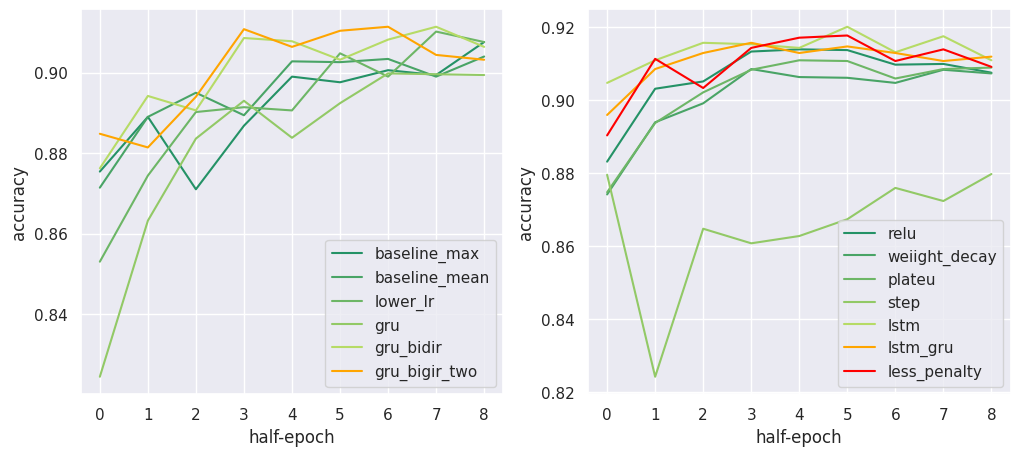

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(baseline_max, label='baseline_max')
ax[0].plot(baseline_mean, label='baseline_mean')
ax[0].plot(lower_lr, label='lower_lr')
ax[0].plot(gru, label='gru')
ax[0].plot(gru_bidir, label='gru_bidir')
ax[0].plot(gru_bidir_two, label='gru_bigir_two', color='orange')
ax[0].set_xlabel('half-epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(relu, label='relu')
ax[1].plot(weiight_decay, label='weiight_decay')
ax[1].plot(plateu, label='plateu')
ax[1].plot(step, label='step')
ax[1].plot(lstm, label='lstm')
ax[1].plot(lstm_gru, label='lstm_gru', color='orange')
ax[1].plot(less_penalty, label='less_penalty', color='red')
ax[1].set_xlabel('half-epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

Как мы видим из графика, наиболее гладкий был у lstm_gru (оранжевая линия, правый график), а наша лучшая модель less_penalty (красная линия, правый график) хоть и смогла достичь в пике лучшего результата, но имела небольшие колебания (помним о масштабе графика). В целом вторая половина моделей (правый график) имеют лучшую сходимость, которая может быть объяснена уменьшением lr.

# Далее идёт дополнительный текст, который необходимо написать из-за бага колаба с печатью последних строк

Просто

Случайный

текст

для

растягивания

документа

из-за

бага

колаба

на

печати

документа

в

пдф

когда

он

отказывается

печатать

последние

несколько

десятков

строк

из-за

какой-то

своей

ошибки

Просто

Случайный

текст

для

растягивания

документа

из-за

бага

колаба

на

печати

документа

в

пдф

когда

он

отказывается

печатать

последние

несколько

десятков

строк

из-за

какой-то

своей

ошибки

Просто

Случайный

текст

для

растягивания

документа

из-за

бага

колаба

на

печати

документа

в

пдф

когда

он

отказывается

печатать

последние

несколько

десятков

строк

из-за

какой-то

своей

ошибки

Просто

Случайный

текст

для

растягивания

документа

из-за

бага

